In [1]:
import importlib
import os, pandas as pd, numpy as np
from joblib import dump, load

import sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
import sod.core.dataset as sod_core_dataset
importlib.reload(sod_core_dataset)
import sod.core.plot as sod_plot
importlib.reload(sod_plot)
# from sod.core.dataset import open_dataset # , normalize_df
# from sod import plot

is_outlier = sod_core_dataset.is_outlier

path = os.path.join(os.getcwd(), '..', 'evaluations/results/cv.globalset.iforest.yaml/evalreports/evaluations.all.hdf')

dfr = pd.read_hdf(path)
print('evaulation dataframe.\n\nColumns:\n' + str(dfr.columns.tolist()))
print('\nclassname distinct values:\n' + str(np.unique(dfr['classname'])))

evaulation dataframe.

Columns:
['% rec.', 'Mean log_loss', 'behaviour', 'classname', 'clf', 'contamination', 'features', 'max_samples', 'n_estimators']

classname distinct values:
['ok' 'outl. (cha. resp. acc <-> vel)' 'outl. (gain X10 or X0.1)'
 'outl. (gain X100 or X0.01)' 'outl. (gain X2 or X0.5)'
 'outl. (wrong inv)' 'unlabeled (Me suspicious outl.)'
 'unlabeled (unknown)']


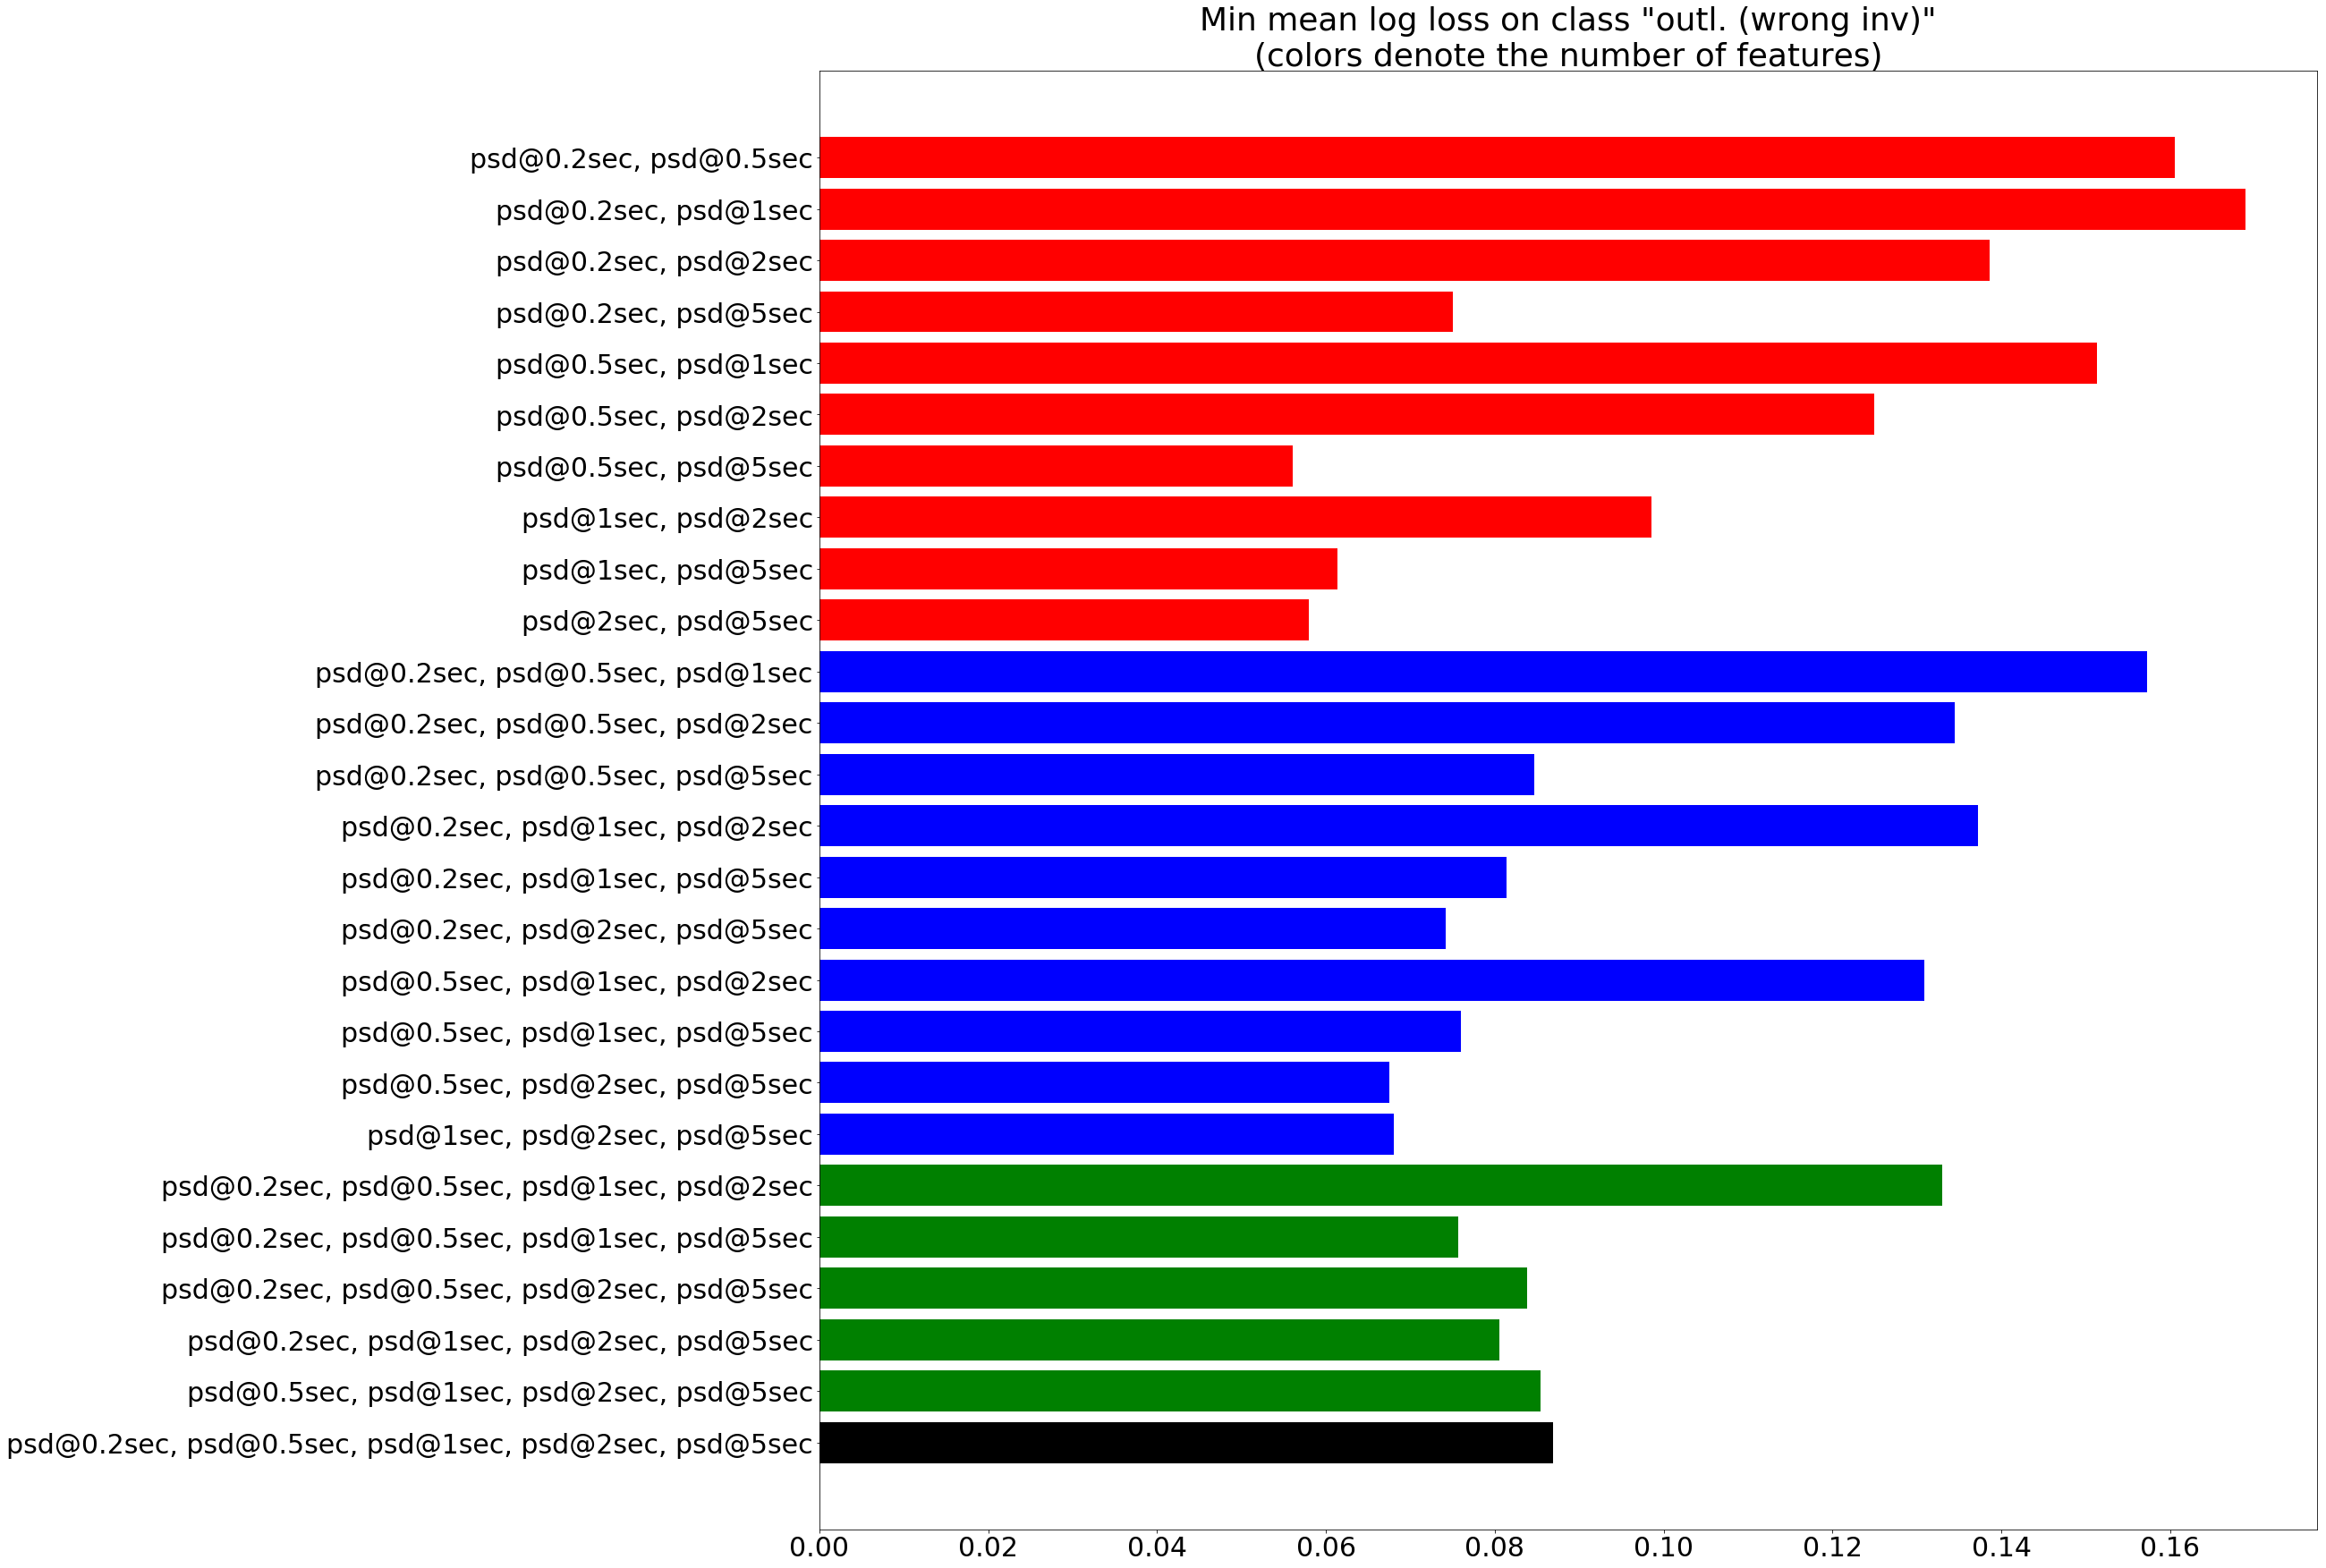

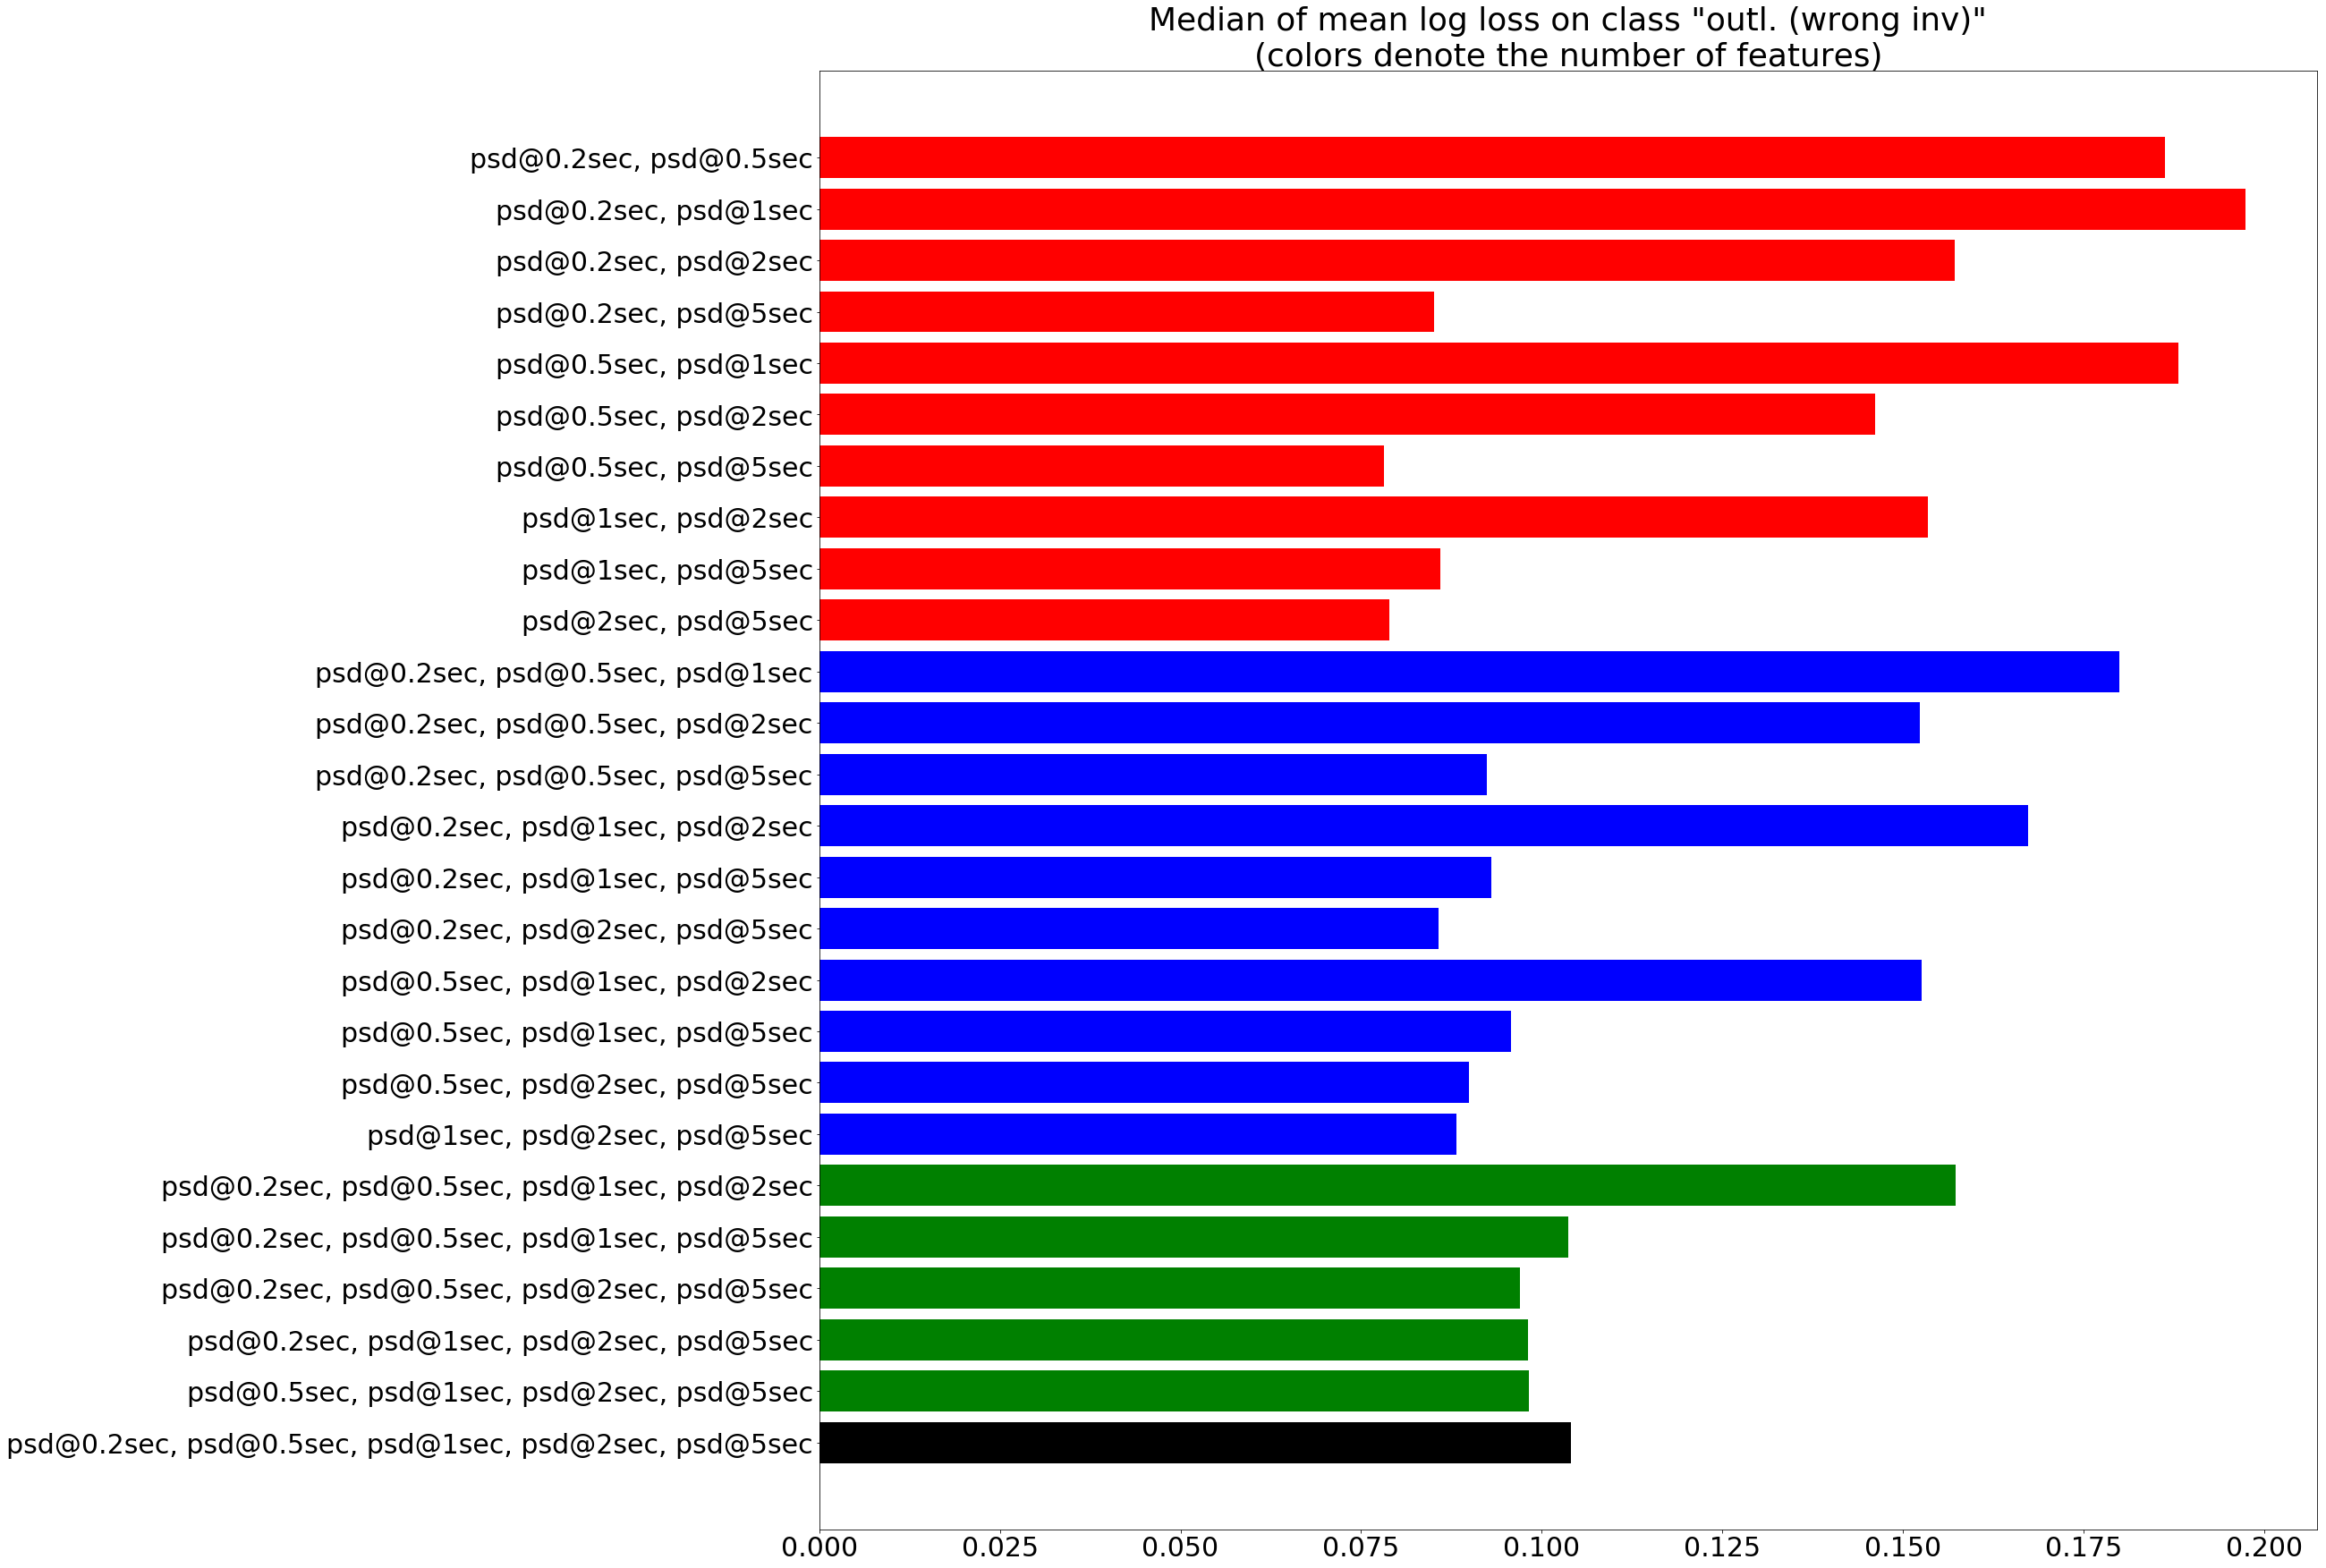

In [8]:
import matplotlib
importlib.reload(matplotlib)
import numpy as np
import matplotlib.pyplot as plt
from contextlib import contextmanager
from collections import defaultdict

%matplotlib inline

@contextmanager
def plotparams(params):
    '''makes temporarily matplotlib params.
    Make sure to run this after %matplotlib inline.
    For info see https://stackoverflow.com/questions/36367986/how-to-make-inline-plots-in-jupyter-notebook-larger'''
    def_params = {k: plt.rcParams[k] for k in params}
    for k, v in params.items():
        plt.rcParams[k] = v
    try:
        yield
    finally:
        for k, v in def_params.items():
            plt.rcParams[k] = v
    


tmp_fig_size = matplotlib.rcParams['figure.figsize']
matplotlib.rcParams['figure.figsize']
# plt.rcParams.update({'font.size': 30})
# plt.rcParams.update({'figure.figsize': (22, 22)})





class_ = 'outl. (wrong inv)'

with plotparams({'figure.figsize': (30, 30), 'font.size': 30}):

    # printing per feature with hbars (https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barh.html)
    numfeat2color = {2: 'r', 3: 'b', 4: 'g', 5: 'k'}

    data = defaultdict(list)
    for _, df_ in dfr.groupby('features'):
        data[_].extend(_ for _ in df_[df_.classname == class_]['Mean log_loss'])

    avg = {_: np.nanmin(data[_]) for _ in data}
    labels = sorted(avg.keys(), key=lambda f: (len(f.split(',')), f), reverse=True)
    colors = [numfeat2color[len(_.split(','))] for _ in labels]
    ypos = np.arange(len(labels))
    plt.barh(ypos, [avg[_] for _ in labels], align='center', color=colors)
    plt.title('Min mean log loss on class "%s"\n(colors denote the number of features)' % class_)
    plt.gca().set_yticks(ypos)
    plt.gca().set_yticklabels((_.replace(",", ", ") for _ in labels))

    # plt.xlabel('number of features')
    # plt.xticks(rotation=90)
    plt.show()

    avg = {_: np.quantile(data[_], 0.5) for _ in data}
    labels = sorted(avg.keys(), key=lambda f: (len(f.split(',')), f), reverse=True)
    ypos = np.arange(len(labels))
    plt.barh(ypos, [avg[_] for _ in labels], align='center', color=colors)
    plt.title('Median of mean log loss on class "%s"\n(colors denote the number of features)' % class_)
    plt.gca().set_yticks(ypos)
    plt.gca().set_yticklabels((_.replace(",", ", ") for _ in labels))

    # labels = sorted(avg.keys())
    # ypos = np.arange(len(labels))
    # plt.bar(avg.keys(), avg.values())
    # plt.title('Median of mean log loss on class "%s" ' % class_)
    # plt.xlabel('number of features')
    # plt.xticks(rotation=90)
    plt.show()

    # print(pd.Series(avg))

In [3]:
# TOMORROW: download 3 models, plot contour
# download the 3 models predictions, group by station, get median and calculate log_loss + correctly classified
# see number of correctly classified per number of segment, and if there is a relation

# OUTLOOK: test on other europe db segments?
# create some other artifacts and see how it works?


In [15]:
root = os.path.abspath(os.path.join(os.getcwd(), '..', 'evaluations', 'results', 'cv.globalset.iforest.yaml'))
assert(os.path.isdir(root))

m_path_half_5 = os.path.abspath(os.path.join(root, 'models', 'IsolationForest?features=psd@0.5sec,psd@5sec&contamination=0.1&max_samples=2048&n_estimators=100&behaviour=new.model'))
m_path_two_5  = os.path.abspath(os.path.join(root, 'models', 'IsolationForest?features=psd@2sec,psd@5sec&contamination=0.05&max_samples=512&n_estimators=100&behaviour=new.model'))
m_path_one_5  = os.path.abspath(os.path.join(root, 'models', 'IsolationForest?features=psd@1sec,psd@5sec&contamination=0.1&max_samples=2048&n_estimators=100&behaviour=new.model'))

clfs = {}
# in Python 3.7.5 keys are sorted by insertion order
clfs['psd@0.5sec, psd@5sec'] = load(m_path_half_5)
clfs['psd@1sec, psd@5sec'] = load(m_path_one_5)
clfs['psd@2sec, psd@5sec'] = load(m_path_two_5)

for n, c in clfs.items():
    print('%s: %s' % (str(n), str(c)))

print('loading source trainset')
dataframe = sod_core_dataset.open_dataset('globalset.hdf', normalize=False, verbose=False)

psd@0.5sec, psd@5sec: IsolationForest(behaviour='new', bootstrap=False, contamination=0.1,
                max_features=1.0, max_samples=2048, n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)
psd@1sec, psd@5sec: IsolationForest(behaviour='new', bootstrap=False, contamination=0.1,
                max_features=1.0, max_samples=2048, n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)
psd@2sec, psd@5sec: IsolationForest(behaviour='new', bootstrap=False, contamination=0.05,
                max_features=1.0, max_samples=512, n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)
loading source trainset



psd@0.5sec, psd@5sec: IsolationForest(behaviour='new', bootstrap=False, contamination=0.1,
                max_features=1.0, max_samples=2048, n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)


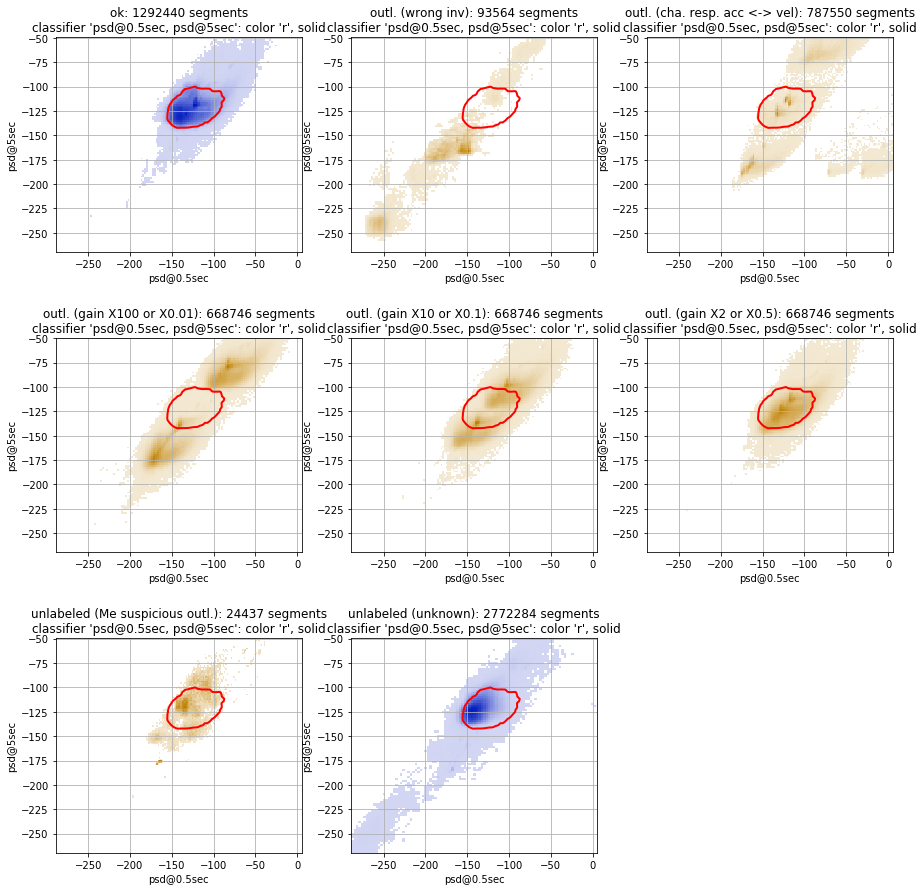


psd@1sec, psd@5sec: IsolationForest(behaviour='new', bootstrap=False, contamination=0.1,
                max_features=1.0, max_samples=2048, n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)


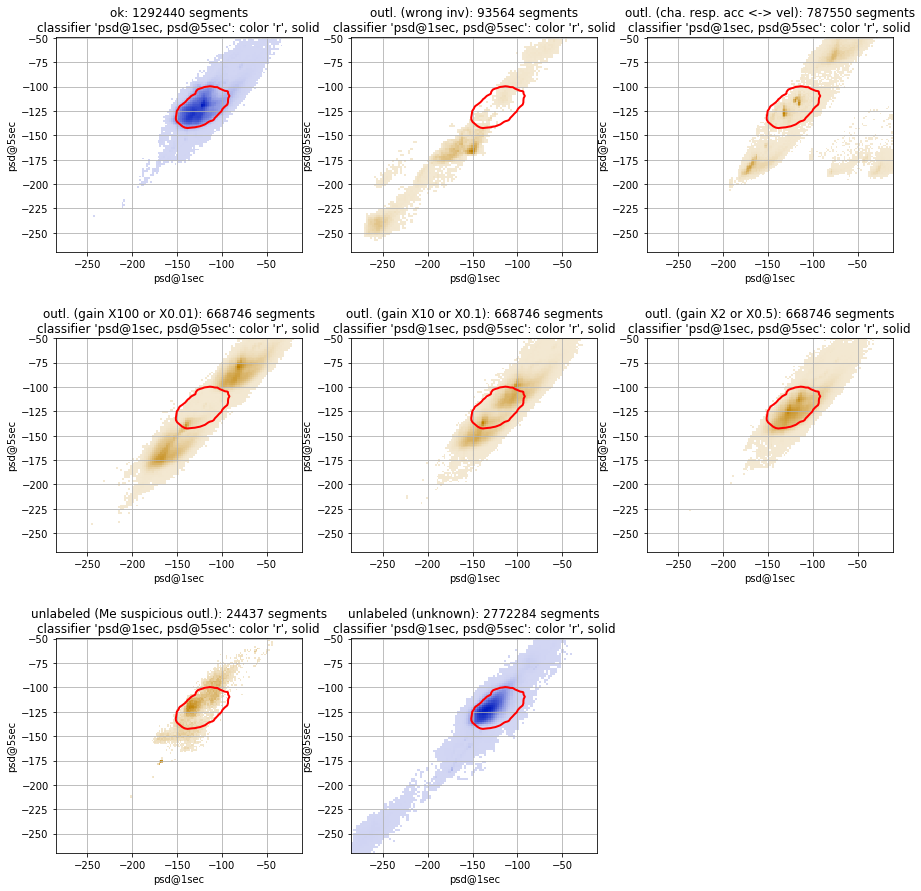


psd@2sec, psd@5sec: IsolationForest(behaviour='new', bootstrap=False, contamination=0.05,
                max_features=1.0, max_samples=512, n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)


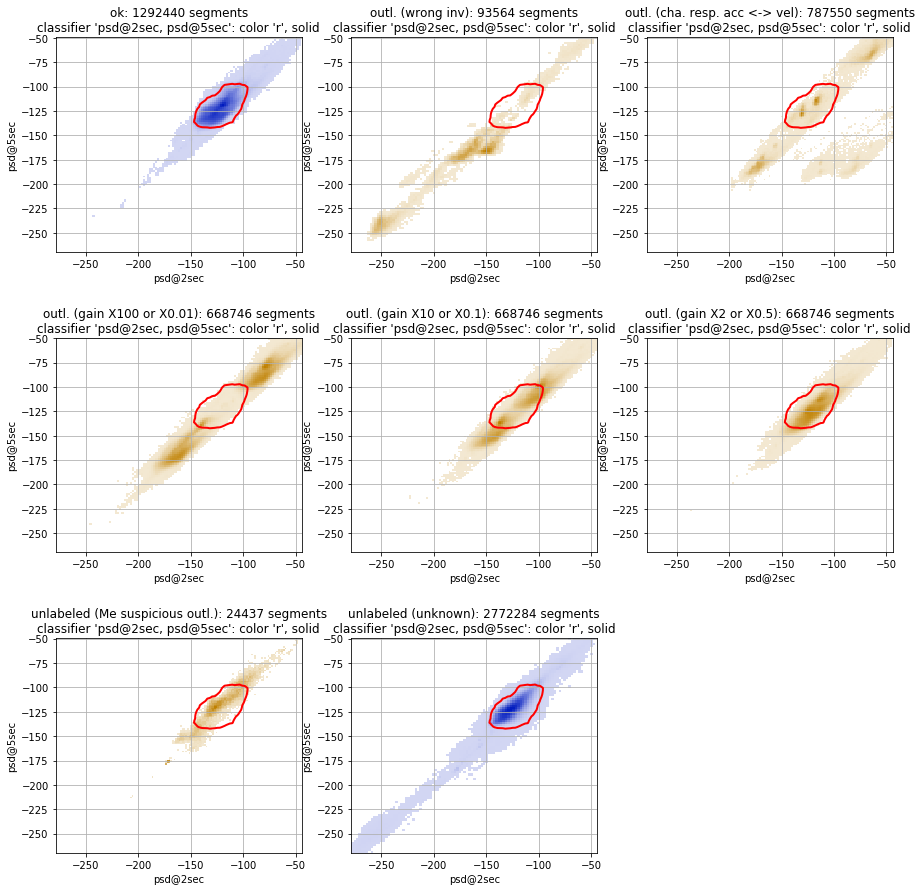

In [27]:
import importlib
import sod.core.plot as sod_plot
importlib.reload(sod_plot)

%matplotlib inline
with plotparams({'figure.figsize': (15, 15)}):
    for clf_key, clf_val in clfs.items():
        print('\n%s: %s' % (str(clf_key), str(clf_val)))
        sod_plot.plot(dataframe, *[_.strip() for _ in clf_key.split(',')], axis_lim=.9901, clfs={clf_key: clf_val})
        plt.show()

In [96]:
p_path_half_5 = os.path.abspath(os.path.join(root, 'predictions', 'IsolationForest?features=psd@0.5sec,psd@5sec&contamination=0.1&max_samples=2048&n_estimators=100&behaviour=new.hdf'))
p_path_two_5  = os.path.abspath(os.path.join(root, 'predictions', 'IsolationForest?features=psd@2sec,psd@5sec&contamination=0.05&max_samples=512&n_estimators=100&behaviour=new.hdf'))
p_path_one_5  = os.path.abspath(os.path.join(root, 'predictions', 'IsolationForest?features=psd@1sec,psd@5sec&contamination=0.1&max_samples=2048&n_estimators=100&behaviour=new.hdf'))

preds_o = {
    'psd@0.5sec, psd@5sec': pd.read_hdf(p_path_half_5),
    'psd@1sec, psd@5sec': pd.read_hdf(p_path_one_5),
    'psd@2sec, psd@5sec': pd.read_hdf(p_path_two_5)
}

print('Opening predictions hdf files\n')

for name, prd_df in preds_o.items():
    print('Decision function values of %s' % str(name))
    dinfo = sod_core_dataset.dataset_info(prd_df)
    print('inliers (min, median, max):')
    _prd_df = prd_df[dinfo.class_selector[dinfo.classnames[0]]]
    print((_prd_df.decision_function.min(), _prd_df.decision_function.median(), _prd_df.decision_function.max()))
    print('outliers (min, median, max):')
    _prd_df = prd_df[dinfo.class_selector[dinfo.classnames[1]]]
    print((_prd_df.decision_function.min(), _prd_df.decision_function.median(), _prd_df.decision_function.max()))
    print()


import sod.core.evaluation as sod_core_eval
importlib.reload(sod_core_eval)
normalize = sod_core_eval.normalize

print('\nMerging with source input dataframe to retreive the channel id and other data')
colz = ['globalset.id', 'subclass', 'window_type', 'outlier']
preds = {}
for name, pred_df in dict(preds_o).items():
    # https://stackoverflow.com/a/22720823
    dfr__ = dataframe.drop_duplicates(subset=colz)
    pred2 = pred_df.merge(dfr__, how='left', on=colz)
    # print(pred2.columns)
    pred2['channel_code'] = pred2['channel_code'].astype('category')
    pred2['cha_id'] = pred2['channel_code'].str[:2]
    assert len(pred2) == len(pred_df)
    pred2['cha_id'] = pred2['cha_id'].astype('category')
    # pred2['quality'] = normalize(pred2['decision_function'], map_to=(0, 1))
    # assert ((pred2['quality'].median() >= 0.5) == (pred2['decision_function'].median() >=0)).all()
        
    preds[name] = pred2
    # print(pred2.columns)

print('\nDone. Predictions dataframes columns:')
print(list(preds.values())[0].columns.tolist())  # one is sufficient
print()

# FIXME: provare a normalizzare sui quantili

Opening predictions hdf files
Decision function values of psd@0.5sec, psd@5sec
inliers (min, median, max):
(-0.35693947774039203, 0.07255932122838979, 0.10972665377052404)
outliers (min, median, max):
(-0.3460104025237925, -0.2998335126365414, 0.09612788974091535)

Decision function values of psd@1sec, psd@5sec
inliers (min, median, max):
(-0.360264531717579, 0.0761810311872993, 0.1146588595147277)
outliers (min, median, max):
(-0.3421204421339581, -0.2857683561822104, 0.10527544043518472)

Decision function values of psd@2sec, psd@5sec
inliers (min, median, max):
(-0.2788989852545458, 0.1238360942038571, 0.17313260742277942)
outliers (min, median, max):
(-0.2761437077666714, -0.24214942397151085, 0.14810070076502185)

Merging with source input dataframe to retreive the channel id and other data
Predictions dataframes columns:
['globalset.id', 'correctly_predicted', 'log_loss', 'decision_function', 'outlier', 'subclass', 'window_type', 'dataset_id', 'psd@0.05sec', 'psd@0.1sec', 'psd@0.

In [97]:
import pandas as pd, numpy as np
import sod.core.evaluation as sod_core_eval
from collections import defaultdict

importlib.reload(sod_core_eval)
normalize = sod_core_eval.normalize

dinfo = sod_core_dataset.dataset_info(dataframe)
classnames = dinfo.classnames[:2] + dinfo.classnames[-2:]
# provide the action to be performed when missclassified. For the first two labels is 'wrong' (ground truth is reliable)
# for the second two is 'to check' (ground trutch is not reliable, it's Dino guess)
actions = ['wrong', 'wrong', 'to check', 'to check']

colz = ['cha_id', 'dataset_id', 'station_id', 'outlier']

print('Confusion matrices where each instance is a distinct channel (ignoring orientation code)')
print('The prediction is taken as the MEDIAN of the predictions for all channel\'s segments')
# print('Notes: CAI: classified as inlier, CAO: classified as outlier')
print('Notes: MQS: mean quality score in [0, 1]: 0=outlier to 1=inlier (good)')
print('')

wrong_stations = []
wrong_stations_to_clf = defaultdict(list)
clf2int = {name: i for i, name in enumerate(preds.keys(), 1)}

for name, pred_df in dict(preds).items():
    print()
    print(name)
    columns = ['ok', 'outl.', 'ok\'s MQS', 'outl.\'s MQS']
    data = defaultdict(list)
    index = []
    wrongs = []
    min_o, max_i = pred_df['decision_function'].min(), pred_df['decision_function'].max() 
    # max_o = -pred_df_o['decision_function'].min()
    # max_o, max_o = pred_df_i['decision_function'].min(), pred_df_i['decision_function'].max()
    for cname, action in zip(classnames, actions):
        csel = dinfo.class_selector[cname]
        dtmp = pred_df[csel(pred_df)]
        inlier, outlier = 0, 0 
        scores_i, scores_o = [], []  # inlier, outlier
        for (cha_id, d_id, s_id, is_outlier), d in dtmp.groupby(colz):
            # val = d['quality'].median()
            val = np.nanmedian(normalize(d['decision_function'], [min_o, max_i], map_to=(0, 1)))
            # negatives are outliers
            write_df = False
            if val < 0.5:  # classified as outlier
                outlier += 1
                scores_o.append(val)
                if not is_outlier:
                    write_df = True
            elif val > 0.5:
                inlier += 1
                scores_i.append(val)
                if is_outlier:
                    write_df = True
            else:
                outlier += 0.5
                inlier += 0.5

            if write_df:
                wrong_stations_to_clf[(cha_id, d_id, s_id)].append(clf2int[name])
                clfnames = wrong_stations_to_clf[(cha_id, d_id, s_id)]
                wrong_stations.append({
                    'action': action,
                    'dataset_id': 'europe' if d_id == 1 else 'me',
                    'station_id': s_id,
                    'cha_id': cha_id,
                    'expected quality': 0 if is_outlier else 1,
                    'quality': val,
                    'misclassified by*': ",".join(str(_) for _ in clfnames),
                    'num segs': len(d)
                })
        data[columns[0]].append(inlier)
        data[columns[1]].append(outlier)
        data[columns[2]].append(np.round(np.nanmean(scores_i), 3))
        data[columns[3]].append(np.round(np.nanmean(scores_o), 3))

    print(pd.DataFrame(index=classnames, data=data).to_string())

    
print('\nPrinting list of unique stations missclassified')
print('*misclassified by: an integer denoting a classifier:')
for key, val in clf2int.items():
    print('%d: %s' % (val, key))
print()

dflist = pd.DataFrame(wrong_stations)
dflist.drop_duplicates(subset=colz[:-1], inplace=True, keep='last')
dflist['loss'] = np.abs(dflist['expected quality'] - dflist['quality'])
dflist.sort_values(by=['action', 'loss', 'misclassified by*'], ascending=False, inplace=True)
dflist.drop(['loss'], axis=1, inplace=True)
dflist.reset_index(drop=True, inplace=True)
# re-order columns:
dflist = dflist[
                ['action',
                 'dataset_id',
                 'station_id',
                 'cha_id',
                 'expected quality',
                 'quality',
                 'misclassified by*',
                 'num segs']
               ]
print(dflist.to_string())

Confusion matrices where each instance is a distinct channel (ignoring orientation code)
The prediction is taken as the MEDIAN of the predictions for all channel's segments
Notes: MQS: mean quality score in [0, 1]: 0=outlier to 1=inlier (good)


psd@0.5sec, psd@5sec
                                   ok  outl.  ok's MQS  outl.'s MQS
ok                                566     15     0.816        0.360
outl. (wrong inv)                   1     56     0.773        0.094
unlabeled (Me suspicious outl.)     9      8     0.774        0.378
unlabeled (unknown)              2154    130     0.806        0.241

psd@1sec, psd@5sec
                                   ok  outl.  ok's MQS  outl.'s MQS
ok                                567     14     0.817        0.334
outl. (wrong inv)                   1     56     0.756        0.110
unlabeled (Me suspicious outl.)    11      6     0.743        0.355
unlabeled (unknown)              2170    114     0.833        0.218

psd@2sec, psd@5sec
             

ROC-like curve?

[1.94673096 0.94673096 0.80866961 0.80864549 0.77362824 0.77338898
 0.75637261 0.75575178 0.43059178 0.42469361 0.41716451 0.39249126
 0.21692799 0.21349688 0.20173443 0.19132644 0.18916526 0.18570011
 0.18549204 0.18369157 0.18364157 0.1825352  0.18171109 0.16671573
 0.16586696 0.16090879 0.16084927 0.15987173 0.14845187 0.1394977
 0.13835831 0.13756516 0.13677153 0.13518284 0.13488412 0.1319998
 0.11707762 0.11604656 0.10408483 0.08818258 0.08659716 0.08606818
 0.08553894 0.06794171 0.06767243 0.06686408 0.06605521 0.06551561
 0.06497576 0.06281374 0.0524415  0.04990686 0.04821459 0.04707058
 0.04652029 0.04291391 0.04126309 0.03631201 0.03545802 0.02987909
 0.02518162 0.02149577 0.00493956]


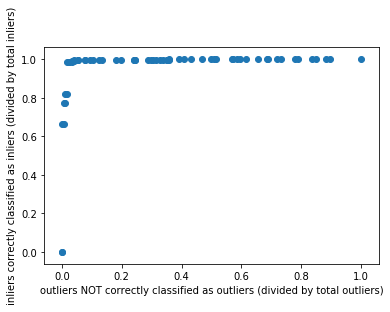

In [110]:
import pandas as pd, numpy as np
import sod.core.evaluation as sod_core_eval
from collections import defaultdict

importlib.reload(sod_core_eval)
normalize = sod_core_eval.normalize

dinfo = sod_core_dataset.dataset_info(dataframe)
classnames = dinfo.classnames[:2]

print('ROC-like curve?\n')

x = {_: 0 for _ in 0.1 * np.arange(1, 10)}
tot = 0

y_pred = []
y_true = []

for name, pred_df in dict(preds).items():
    columns = ['ok', 'outl.', 'ok\'s MQS', 'outl.\'s MQS']
    data = defaultdict(list)
    index = []
    wrongs = []
    min_o, max_i = pred_df['decision_function'].min(), pred_df['decision_function'].max() 
    # max_o = -pred_df_o['decision_function'].min()
    # max_o, max_o = pred_df_i['decision_function'].min(), pred_df_i['decision_function'].max()
    for cname in classnames:
        csel = dinfo.class_selector[cname]
        dtmp = pred_df[csel(pred_df)]
        inlier, outlier = 0, 0 
        scores_i, scores_o = [], []  # inlier, outlier
        for (cha_id, d_id, s_id, is_outlier), d in dtmp.groupby(colz):
            tot += 1
            # val = d['quality'].median()
            val = np.nanmedian(normalize(d['decision_function'], [min_o, max_i], map_to=(0, 1)))
            
            y_pred.append(val)
            y_true.append(-1 if is_outlier else 1)

            # negatives are outliers
#             for th in x.keys():
#                 if val >= th and not is_outlier:
#                     x[th] += 1
#                 elif val < th and is_outlier:
#                     x[th] += 1
# print(x)

# plt.bar(x.keys(), np.array(list(x.values())) / tot)
# plt.show()

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

plt.scatter(fpr, tpr)
plt.ylabel('inliers correctly classified as inliers (divided by total inliers)')
plt.xlabel('outliers NOT correctly classified as outliers (divided by total outliers)')
print(thresholds)